# LDED Audiovisual Fusion 

Author: Chen Lequn.
Created on March 2023

### Notebook 1(d): Sony Video Image Processing
- Extract spatter and plume features

In [1]:
## Required python libraries
import pandas as pd
import numpy as np
import scipy as sp
import scipy.signal
import pandas as pd
from glob import glob
import os
import math
import sys
from scipy.interpolate import griddata
import cv2
# to make this notebook's output stable across runs
np.random.seed(42)

pd.plotting.register_matplotlib_converters()


import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline
import seaborn as sns
import librosa
import matplotlib.font_manager as font_manager

#---------------opencv------------------------
import cv2
from IPython.display import Image, display
# from tqdm import tqdm
from tqdm.notebook import tqdm

In [2]:
PROJECT_ROOT_DIR = "../"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'sony_image_processing')
os.makedirs(IMAGE_PATH, exist_ok=True)

Multimodal_dataset_PATH = "/home/chenlequn/pan1/Dataset/LDED_acoustic_visual_monitoring_dataset"
Dataset_path = os.path.join(Multimodal_dataset_PATH, f'25Hz')
                            

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

In [15]:
def get_sample_directories(base_path, sample_numbers):
    sample_directories = []
    for sample_number in sample_numbers:
        sample_directories.append(os.path.join(base_path, f'{sample_number}'))
    return sample_directories


samples = [21, 22, 23, 24, 26, 32]
sample_directories = get_sample_directories(Dataset_path, samples)

# Get lists of image and audio directories for each sample
sony_camera_images_directories = [os.path.join(sample_dir, 'sony_camera_images') for sample_dir in sample_directories]
sony_camera_images_directories

['/home/chenlequn/pan1/Dataset/LDED_acoustic_visual_monitoring_dataset/25Hz/21/sony_camera_images',
 '/home/chenlequn/pan1/Dataset/LDED_acoustic_visual_monitoring_dataset/25Hz/22/sony_camera_images',
 '/home/chenlequn/pan1/Dataset/LDED_acoustic_visual_monitoring_dataset/25Hz/23/sony_camera_images',
 '/home/chenlequn/pan1/Dataset/LDED_acoustic_visual_monitoring_dataset/25Hz/24/sony_camera_images',
 '/home/chenlequn/pan1/Dataset/LDED_acoustic_visual_monitoring_dataset/25Hz/26/sony_camera_images',
 '/home/chenlequn/pan1/Dataset/LDED_acoustic_visual_monitoring_dataset/25Hz/32/sony_camera_images']

### Image Processing Algorithm

In [5]:
def create_mask(image_shape, vertices):
    mask = np.ones(image_shape, dtype=np.uint8) * 255  # Create a mask that is all white
    cv2.fillPoly(mask, [np.array(vertices, dtype=np.int32)], 0)  # Fill the polygon with black (0)
    return mask

def crop_image(image, left=0, top=0, right=0, bottom=0):
    height, width = image.shape[:2]
    new_right = width - right
    new_bottom = height - bottom
    cropped_image = image[top:new_bottom, left:new_right]
    return cropped_image

def filter_contours_by_area(contours, min_area1=1, max_area2=50, min_area3=100):
    filtered_contours = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        # Include contours that are between min_area1 and max_area2 or larger than min_area3
        if (min_area1 <= area < max_area2) or (area >= min_area3):
            filtered_contours.append(cnt)
    return filtered_contours


# Function to find contours and quantify the features
def quantify_features(thresholded, min_area1=1, max_area2=50, min_area3=100):
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = filter_contours_by_area(contours, min_area1, max_area2, min_area3)
    num_features = len(filtered_contours)
    total_feature_area = sum(cv2.contourArea(cnt) for cnt in filtered_contours)
    return filtered_contours, num_features, total_feature_area


def adjust_mask_vertices(mask_vertices, crop_params):
    left, top, right, bottom = crop_params
    adjusted_vertices = []
    for vertex in mask_vertices:
        adjusted_vertex = (vertex[0] - left, vertex[1] - top)
        adjusted_vertices.append(adjusted_vertex)
    return np.array(adjusted_vertices, dtype=np.int32)



def apply_morphological_opening(image, kernel_size=(1, 40)):
    """
    Apply morphological opening to the image to remove horizontal banding.
    
    Parameters:
    image (np.array): The input image on which to perform the operation.
    kernel_size (tuple): The size of the structuring element.
    
    Returns:
    np.array: The image after morphological opening.
    """
    # Create the horizontal kernel for morphological opening
    # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    kernel = np.ones((5,5),np.uint8)
    
    # Apply the morphological opening operation
    opened_image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    
    return opened_image


def preprocess_image(image_path, threshold_value=90, crop_params=None, mask_vertices=None):
    # Load the image
    image_original = cv2.imread(image_path)
    # Convert to grayscale
    gray = cv2.cvtColor(image_original, cv2.COLOR_BGR2GRAY)
    # Crop the image if crop parameters are provided
    cropped = gray.copy()
    if crop_params:
        cropped = crop_image(cropped, *crop_params)
    # Apply a fixed threshold
    _, thresholded = cv2.threshold(cropped, threshold_value, 255, cv2.THRESH_BINARY)
    
    # Apply mask if vertices are provided
    masked = thresholded.copy()
    if mask_vertices and crop_params:
        # Adjust the mask vertices based on the crop parameters
        adjusted_mask_vertices = adjust_mask_vertices(mask_vertices, crop_params)
        # Create the mask with the adjusted vertices
        mask = create_mask(thresholded.shape, adjusted_mask_vertices)
        # Apply the mask to exclude the polygon area after thresholding
        masked = cv2.bitwise_and(masked, mask)
    
    return image_original, gray, cropped, thresholded, masked


def visualize_results(original_image, cropped_image, thresholded, filtered_contours, crop_params, sample_number, image_index):
    contour_features_image = original_image.copy()
    crop_offsets = (crop_params[0], crop_params[1])
    # Adjust contours to match the original image's coordinate system
    adjusted_contours = [cnt + np.array([crop_offsets]) for cnt in filtered_contours]
    # Draw the adjusted contours on the original image
    cv2.drawContours(contour_features_image, adjusted_contours, -1, (0, 255, 0), 2)
    # Convert images to RGB for displaying with matplotlib
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    cropped_image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
    threshold_rgb = cv2.cvtColor(thresholded, cv2.COLOR_GRAY2RGB)
    contour_features_image_rgb = cv2.cvtColor(contour_features_image, cv2.COLOR_BGR2RGB)
    
    # Display the images in a 2x2 grid
    plt.figure(figsize=(20, 20))  # Adjusted for 2x2 grid
    plt.subplot(2, 2, 1)
    plt.title('Original Image')
    plt.imshow(original_image_rgb)
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.title('Cropped Image')
    plt.imshow(cropped_image_rgb)
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.title('Thresholded Binary Image')
    plt.imshow(threshold_rgb)
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.title('Detected Features Contours')
    plt.imshow(contour_features_image_rgb)
    plt.axis('off')

    # plt.show()
    # Define a list of tuples containing the images and their titles
    images_and_titles = [
        (original_image_rgb, 'Original'),
        (cropped_image_rgb, 'Cropped'),
        (threshold_rgb, 'Thresholded'),
        (contour_features_image_rgb, 'Contours')
    ]
    
    # Display and save the images
    for i, (image, title) in enumerate(images_and_titles):
        plt.figure(figsize=(10, 10))  # Size for individual images
        plt.title(f'{title} Image')
        plt.imshow(image)
        plt.axis('off')
        
        # Save the figure with a concise file name
        concise_title = title.lower()
        file_name = f'sample_{sample_number}_idx_{image_index}_{concise_title}'
        save_fig(file_name)
        plt.close()  # Close the figure after saving to free memory

### Function to identify the mask boundary points

In [6]:
# Define a function to construct the image path based on sample number and image index
def construct_image_path(directories, sample_number, image_index):
    """
    Construct the path to an image given the base directories, sample number, and image index.

    Parameters:
    directories (list): List of base directories for image samples.
    sample_number (int): The sample number to find in the directories.
    image_index (int): The image index to select from the sample.

    Returns:
    str: The full path to the desired image.
    """
    # Filter the directory list for the specified sample number
    directory = next((d for d in directories if f"/{sample_number}/" in d), None)
    if directory is None:
        return None
    
    # Construct the full image path
    image_path = f"{directory}/sample_{sample_number}_{image_index}.png"
    return image_path


def draw_circle(event, x, y, flags, param):
    global polygon_vertices
    
    if event == cv2.EVENT_LBUTTONDOWN:
        # Add the point to the list of vertices
        polygon_vertices.append((x, y))
        # Draw a small circle at the point where we clicked
        cv2.circle(img, (x, y), 3, (255, 0, 0), -1)
        # Display the image with the points marked
        cv2.imshow('image', img)
        print(f"Point added: {(x, y)}")  # Print the point coordinates

## Select One Image as an Example

In [7]:
sample_number = 22
image_index = 1993
image_path = construct_image_path(sony_camera_images_directories, sample_number, image_index)

#### Find the mask

In [7]:
if image_path:
    # Initialize the list to store polygon vertices
    polygon_vertices = []
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Image not found at {image_path}")
    # Display the image
    cv2.imshow('image', img)
    # Set mouse callback function with polygon_vertices as parameter
    cv2.setMouseCallback('image', draw_circle)
    print("Click on the image to select the vertices of the polygon. Press any key to exit.")

    # Wait until a key is pressed
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Print out the selected coordinates
    print("Selected polygon vertices:")
    print(polygon_vertices)
    
else:
    print("Invalid sample number or directory not found.")

Click on the image to select the vertices of the polygon. Press any key to exit.
Point added: (271, 276)
Point added: (436, 307)
Point added: (791, 348)
Point added: (901, 365)
Point added: (1046, 362)
Point added: (1160, 363)
Point added: (1298, 352)
Point added: (1519, 345)
Point added: (1698, 320)
Point added: (1760, 250)
Point added: (1792, 102)
Point added: (1804, 38)
Point added: (1729, 3)
Point added: (486, 4)
Point added: (239, 7)
Point added: (51, 26)
Point added: (80, 145)
Selected polygon vertices:
[(271, 276), (436, 307), (791, 348), (901, 365), (1046, 362), (1160, 363), (1298, 352), (1519, 345), (1698, 320), (1760, 250), (1792, 102), (1804, 38), (1729, 3), (486, 4), (239, 7), (51, 26), (80, 145)]


### Visualize the effect

- mask: [(271, 276), (436, 307), (791, 348), (901, 365), (1046, 362), (1160, 363), (1298, 352), (1519, 345), (1698, 320), (1760, 250), (1792, 102), (1804, 38), (1729, 3), (486, 4), (239, 7), (51, 26), (80, 145)]
 
- Sample 21: crop parameter: (500, 200, 600, 300)

- Sample 22: crop parameter: (500, 200, 600, 300)
 
- Sample 23: crop parameter: (500, 200, 600, 300)

- Sample 24: crop parameter: (500, 200, 600, 300)

- Sample 26: Crop parameter: (600, 200, 500, 300)

- Sample 32: Crop parameter: (600, 400, 500, 100)

In [31]:
sample_number = 32
image_index = 10240
image_path = construct_image_path(sony_camera_images_directories, sample_number, image_index)
image_path

'/home/chenlequn/pan1/Dataset/LDED_acoustic_visual_monitoring_dataset/25Hz/32/sony_camera_images/sample_32_10240.png'

Number of spatters: 108, Total area of features: 9048.0
Saving figure sample_32_idx_10240_original
Saving figure sample_32_idx_10240_cropped
Saving figure sample_32_idx_10240_thresholded
Saving figure sample_32_idx_10240_contours


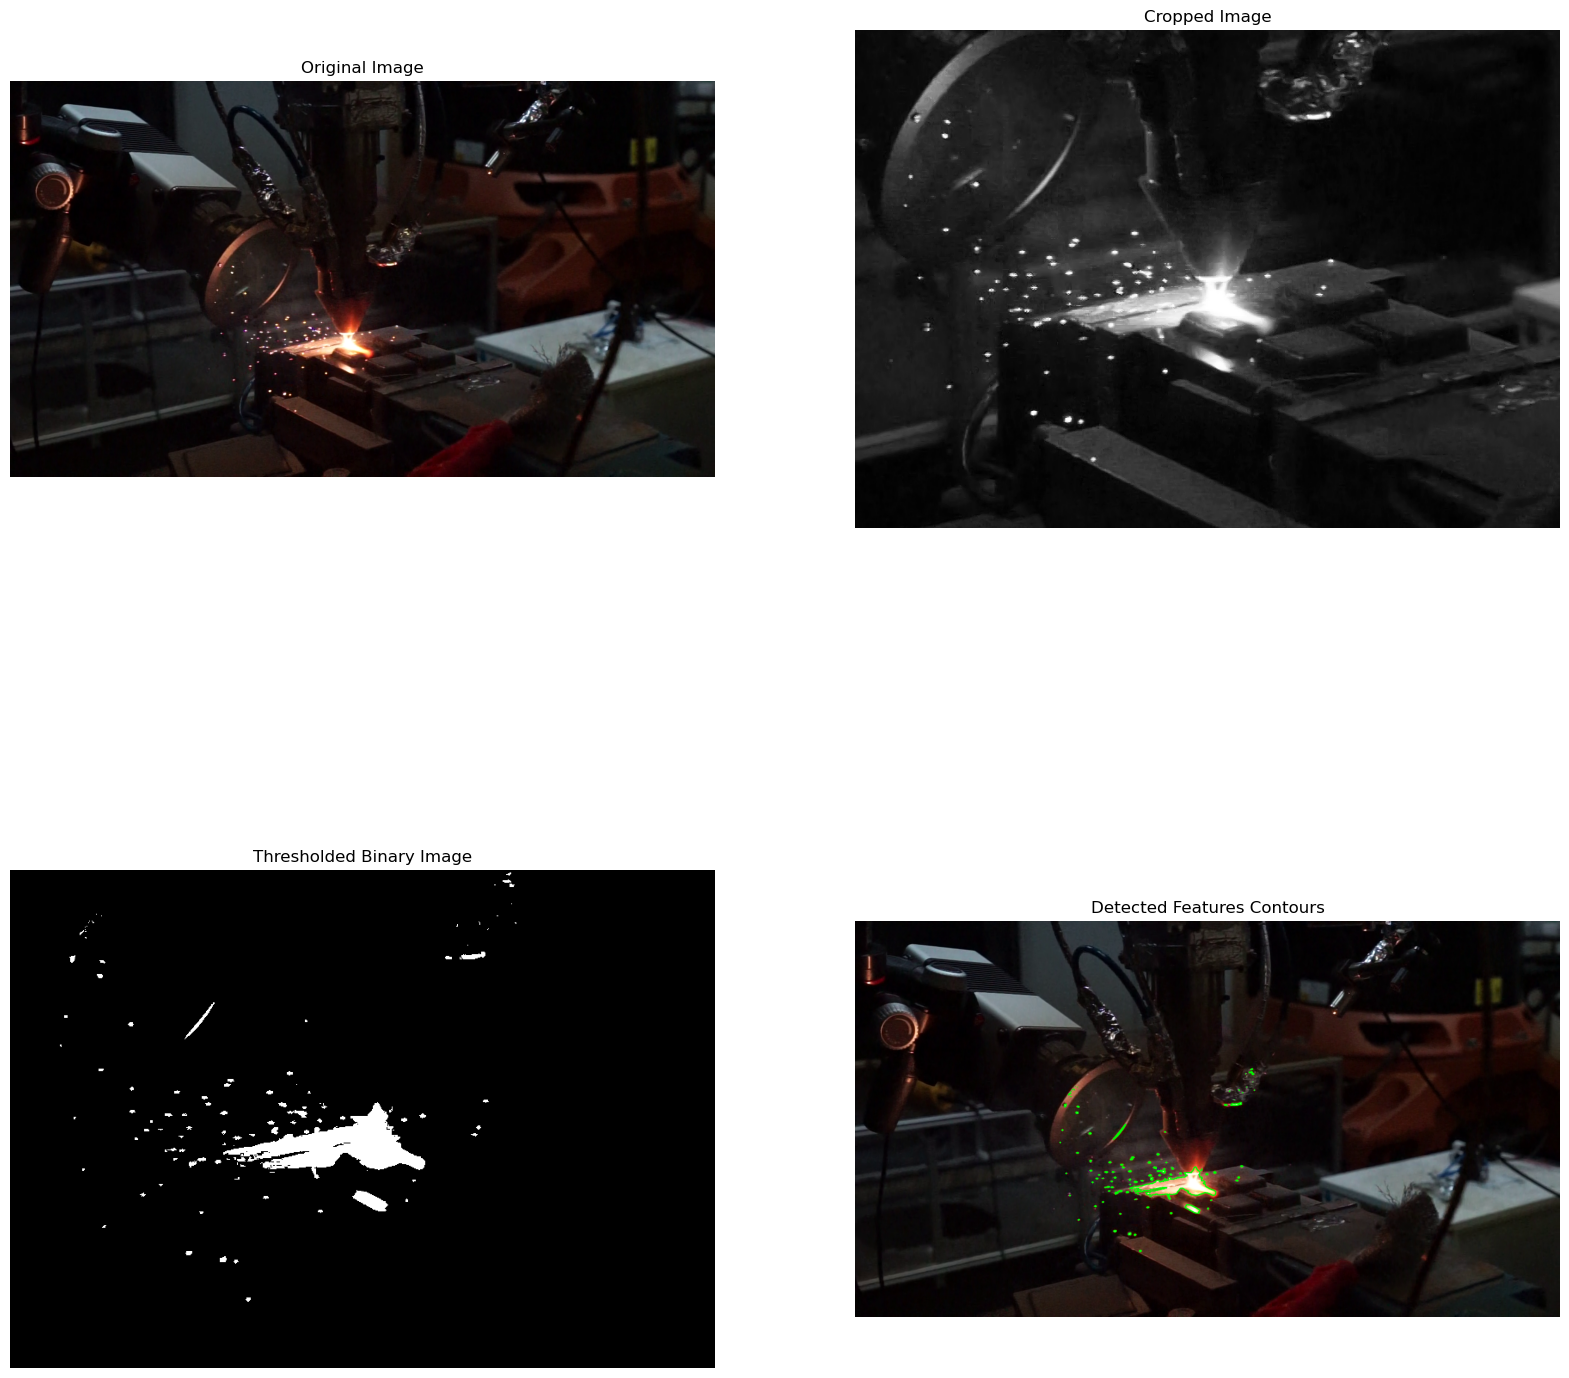

In [33]:
mask = [(271, 276), (436, 307), (791, 348), (901, 365), (1046, 362), (1160, 363), (1298, 352), (1519, 345), (1698, 320), (1760, 250), (1792, 102), (1804, 38), (1729, 3), (486, 4), (239, 7), (51, 26), (80, 145)]

crop_params = (500, 400, 600, 100)  # Example crop parameters (left, top, right, bottom)


# Call the function with an example image path and processing parameters
image_original, gray, cropped, thresholded, masked = preprocess_image(image_path, threshold_value=150,
                                                                      crop_params=crop_params, mask_vertices=mask)

filtered_contours, num_features, total_feature_area = quantify_features(masked, min_area1=0, max_area2=800, min_area3=1000) #20000
print(f"Number of spatters: {num_features}, Total area of features: {total_feature_area}")

visualize_results(image_original, cropped, thresholded, filtered_contours, crop_params, sample_number, image_index)

### Batch processing

In [9]:
def extract_spatter_plume_features(image_directories, sample_number, crop_params, mask, threshold_value=150, min_area1=0, max_area2=800, min_area3=20000):
    # Prepare a list to accumulate results
    results = []

    total_images = sum([len(os.listdir(img_dir)) for img_dir in image_directories if os.path.isdir(img_dir)])
    pbar = tqdm(total=total_images, desc="Processing images")

    for img_dir in image_directories:
        if os.path.isdir(img_dir):
            for img_name in os.listdir(img_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(img_dir, img_name)
                    # Apply the image processing pipeline
                    _, _, _, _, masked = preprocess_image(img_path, threshold_value=threshold_value, 
                                                          crop_params=crop_params, mask_vertices=mask)
                    image_original, gray, cropped, thresholded, masked = preprocess_image(image_path, threshold_value=150,
                                                                          crop_params=crop_params, mask_vertices=mask)
                    
                    filtered_contours, num_features, total_feature_area = quantify_features(masked, min_area1=min_area1, 
                                                                                            max_area2=max_area2, min_area3=min_area3)
    
                    # Check for significant vapour plume
                    vapour_plume = any(cv2.contourArea(cnt) >= min_area3 for cnt in filtered_contours)
    
                    # Append the results
                    results.append({
                        "sample_number": sample_number,
                        "image_file_name": img_name,
                        "number_of_spatters": num_features,
                        "total_area_of_spatters": total_feature_area,
                        "vapour_plume_detected": vapour_plume
                    })
    
                    # Update the progress bar
                    pbar.update(1)

    # Close the progress bar
    pbar.close()

    # Convert the results list to a pandas DataFrame
    df_spatter_plume_features = pd.DataFrame(results)

    return df_spatter_plume_features

In [10]:
df_spatter_plume_features = extract_spatter_plume_features(sony_camera_images_directories, sample_number, crop_params=crop_params, mask=mask, 
                                                           threshold_value=150, min_area1=0, max_area2=800, min_area3=20000)
# print(df_spatter_plume_features)

Processing images:   0%|          | 0/29275 [00:00<?, ?it/s]

KeyboardInterrupt: 